# Collegamento Drive

In [1]:
!df -h /content/drive

df: /content/drive: No such file or directory


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!ls '/content/drive/My Drive/SonART/Demo'

Mounted at /content/drive
'asmr EGG CRACKING sound.mp3'
'Bird Flapping Wings Sound Effect.mp3'
'Busy Street [Sound Effect].mp3'
 cat-purring-68797.mp3
 egg-crack5-104555.mp3
 egg-cracking-6844.mp3
'Egg Shell Crack Sound Effect - Egg Cracking sound.mp3'
'Heart Beat [SOUND EFFECT].mp3'
'Hungry Cat Sound Effects - Hungry Cat Meowing Sound shorts.mp3'
'Long Mud Pour Sound Effect.mp3'
'Meow Sound Effect.mp3'
' Royalty-Free Sounds.mp3'
 saved_model
'Seagull - Sound Effect.mp3'
'seagull sound.mp3'
'Sea Waves - Sound Effect.mp3'
'SonART Demo v1.wav'
'SonART Demo v2.wav'
'SonART Demo v3.wav'
'SonART Demo v4.wav'
'SonART Demo v5.wav'
'SonART Demo v6.wav'
'SonART Demo v7.wav'
'SonART Demo v8.wav'
'Sound effect - Campane - Bells.mp3'
 splash-6213.mp3


# IMPORT

In [3]:
!pip install torchlibrosa

In [4]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import librosa
import torch

In [5]:
path = "/content/drive/MyDrive/SonART/Code/panns_inference"
if os.path.exists(path):
    print("La cartella esiste!")
else:
    print("Errore: La cartella non è stata trovata. Controlla il percorso.")

La cartella esiste!


In [6]:
sys.path.append("/content/drive/MyDrive/SonART/Code/panns_inference")

In [7]:
from panns_inference import AudioTagging, SoundEventDetection, labels

# CREAZIONE MODELLO E CARICAMENTO SUL DRIVE

In [8]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]],
            clipwise_output[sorted_indexes[k]]))

In [9]:
def plot_sound_event_detection_result(framewise_output):
    """Visualization of sound event detection result.

    Args:
      framewise_output: (time_steps, classes_num)
    """
    out_fig_path = 'results/sed_result.png'
    os.makedirs(os.path.dirname(out_fig_path), exist_ok=True)

    classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:5]

    ix_to_lb = {i : label for i, label in enumerate(labels)}
    lines = []
    for idx in idxes:
        line, = plt.plot(framewise_output[:, idx], label=ix_to_lb[idx])
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('Frames')
    plt.ylabel('Probability')
    plt.ylim(0, 1.)
    plt.savefig(out_fig_path)
    print('Save fig to {}'.format(out_fig_path))

------ Audio tagging ------
Checkpoint path: /content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth
✅ La cartella esiste già: /content/drive/My Drive/SonART/saved_model/panns
✅ Il file esiste già, nessun download necessario.
💾 Modello istanziato salvato su Drive: /content/drive/My Drive/SonART/saved_model/panns/panns_model.pth
GPU number: 1
Music: 0.378
Bird: 0.153
Duck: 0.131
Animal: 0.089
Goose: 0.083
Honk: 0.074
Bird vocalization, bird call, bird song: 0.065
Quack: 0.045
Outside, rural or natural: 0.043
Fowl: 0.039
------ Sound event detection ------
Checkpoint path: /content/drive/My Drive/SonART/saved_model/panns/Cnn14_DecisionLevelMax.pth
GPU number: 1
Save fig to results/sed_result.png


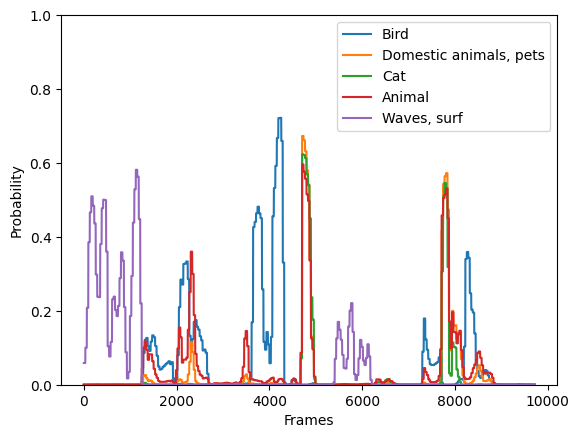

In [10]:
device = 'cuda' # 'cuda' | 'cpu'
audio_path = "/content/drive/My Drive/SonART/Demo/SonART Demo v8.wav"
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)
audio = audio[None, :]  # (batch_size, segment_samples)

print('------ Audio tagging ------')
at = AudioTagging(model=None, checkpoint_path=None, device=device)
(clipwise_output, embedding) = at.inference(audio)
"""clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

print_audio_tagging_result(clipwise_output[0])

print('------ Sound event detection ------')
sed = SoundEventDetection(
    checkpoint_path=None,
    device=device,
    interpolate_mode='nearest', # 'nearest'
)
framewise_output = sed.inference(audio)
"""(batch_size, time_steps, classes_num)"""

plot_sound_event_detection_result(framewise_output[0])

# RECUPERA MODELLO DAL DRIVE

In [11]:
# Percorso del modello su Drive
checkpoint_path = "/content/drive/My Drive/SonART/saved_model/panns/panns_model.pth"

# Carica il modello salvato
model = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu", weights_only=False)

# Modello base ottimizzato

In [12]:
def best_tag(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    return sorted_indexes[0]

In [13]:
audio_path = "/content/drive/My Drive/SonART/Demo/SonART Demo v8.wav"
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)

In [14]:
# **Specifica la durata dei segmenti in secondi**
segment_duration = 3 # Durata del segmento in secondi (esempio: 2 secondi)
hop_duration = 1   # Durata del salto tra segmenti in secondi (esempio: 1 secondo)

# Calcolare la lunghezza di ogni segmento in campioni
segment_length = int(segment_duration * 32000)
hop_length = int(hop_duration * 32000)

# Dividere il waveform in segmenti con il salto specificato
segments = []
for start in range(0, len(audio) - segment_length + 1, hop_length):
    segment = audio[start:start + segment_length]
    segments.append(segment)

# Aggiungere l'ultimo segmento se non coperto dal ciclo (padding se necessario)
if len(audio) % hop_length != 0:
    last_segment = audio[-segment_length:]
    segments.append(last_segment)

# Trasformare i segmenti in un array numpy
segments = np.stack(segments)

# Mostrare dettagli
print(f"Numero di segmenti: {len(segments)}, Forma di ogni segmento: {segments[0].shape}")

Numero di segmenti: 96, Forma di ogni segmento: (96000,)


In [15]:
tag_list = []
device = 'cuda' # 'cuda' | 'cpu'
at = AudioTagging(model=model, checkpoint_path='/content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth', device=device)

Checkpoint path: /content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth
✅ La cartella esiste già: /content/drive/My Drive/SonART/saved_model/panns
✅ Il file esiste già, nessun download necessario.
Il modello esiste già!
GPU number: 1


In [16]:
for segment in segments:
  segment = segment[None, :]  # (batch_size, segment_samples)

  #at = AudioTagging(model=model, checkpoint_path='/content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth', device=device)
  (clipwise_output, embedding) = at.inference(segment)
  """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

  index = best_tag(clipwise_output[0])
  predicted_class = np.array(labels)[index]
  clipwise_output = clipwise_output[0]


  print('{}: {:.3f}'.format(predicted_class,clipwise_output[index]))
  tag_list.append(predicted_class)

Waves, surf: 0.700
Waves, surf: 0.720
Waves, surf: 0.748
Waves, surf: 0.748
Waves, surf: 0.757
Waves, surf: 0.678
Waves, surf: 0.715
Waves, surf: 0.635
Waves, surf: 0.474
Waves, surf: 0.704
Waves, surf: 0.748
Honk: 0.513
Goose: 0.703
Honk: 0.762
Honk: 0.694
Honk: 0.669
Honk: 0.655
Honk: 0.617
Goose: 0.578
Owl: 0.317
Owl: 0.586
Animal: 0.320
Honk: 0.561
Honk: 0.715
Honk: 0.732
Goose: 0.779
Goose: 0.633
Pour: 0.155
Boat, Water vehicle: 0.212
Music: 0.229
Music: 0.190
Music: 0.172
Animal: 0.227
Animal: 0.320
Animal: 0.312
Bird: 0.323
Bird: 0.374
Bird flight, flapping wings: 0.361
Bird flight, flapping wings: 0.196
Bird: 0.588
Bird: 0.727
Bird: 0.638
Bird: 0.531
Vehicle: 0.612
Vehicle: 0.719
Animal: 0.908
Cat: 0.888
Cat: 0.919
Cat: 0.850
Cat: 0.768
Pulse: 0.512
Pulse: 0.467
Heart sounds, heartbeat: 0.390
Waves, surf: 0.440
Waves, surf: 0.703
Waves, surf: 0.645
Waves, surf: 0.571
Waves, surf: 0.707
Waves, surf: 0.557
Waves, surf: 0.560
Waves, surf: 0.302
Music: 0.296
Music: 0.258
Purr: 0.64

# Versione DEMO ottimizzata

In [26]:
# Variabile per tracciare la parola precedentemente stampata
last_printed_word = None
# Variabile per tracciare la parola precedente all'iterazione attuale
previous_word = None

tag_list = []

for segment in segments:
  segment = segment[None, :]  # (batch_size, segment_samples)

  (clipwise_output, embedding) = at.inference(segment)
  """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

  index = best_tag(clipwise_output[0])
  predicted_class = np.array(labels)[index]
  clipwise_output = clipwise_output[0]

  # Stampa solo se la parola si ripete almeno 2 volte di fila e non è la stessa della precedente
  if predicted_class == previous_word:
      if predicted_class != last_printed_word:
          if(clipwise_output[index] >= 0.400):
            print('{}: {:.3f}'.format(predicted_class,
            clipwise_output[index]))
            tag_list.append(predicted_class)
            last_printed_word = predicted_class  # Aggiorna l'ultima parola stampata
  else:
      previous_word = predicted_class  # Aggiorna la parola precedente solo se non è la stessa


Waves, surf: 0.720
Honk: 0.694
Owl: 0.586
Honk: 0.715
Goose: 0.633
Bird: 0.727
Vehicle: 0.719
Cat: 0.919
Pulse: 0.467
Waves, surf: 0.703
Purr: 0.568
Honk: 0.771
Cat: 0.706
Church bell: 0.695
